# Проведение А/В-теста

Источник данных: https://www.kaggle.com/code/kavitabhagwani/marketing-campaign-analysis-basics

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu
from matplotlib.ticker import PercentFormatter

In [116]:
marketing_campaign= pd.read_csv('~/marketing_campaign.csv')
marketing_campaign.head()

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True


In [117]:
users = pd.read_csv('~/users.csv')
users.head()

,user_id,age_group,language_preferred
0,a1000,0-18 years,English
1,a1001,19-24 years,English
2,a1002,24-30 years,English
3,a1003,30-36 years,English
4,a1004,36-45 years,English


In [118]:
marketing_campaign.shape

(10037, 6)

In [119]:
users.shape

(10037, 3)

In [120]:
users = users.merge(marketing_campaign, on ='user_id')
users.head()

,user_id,age_group,language_preferred,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,0-18 years,English,1/1/18,House Ads,personalization,English,True
1,a1001,19-24 years,English,1/1/18,House Ads,personalization,English,True
2,a1002,24-30 years,English,1/1/18,House Ads,personalization,English,True
3,a1003,30-36 years,English,1/1/18,House Ads,personalization,English,True
4,a1004,36-45 years,English,1/1/18,House Ads,personalization,English,True


In [162]:
users['is_correct_lang'] = np.where(users['language_preferred'] == users['language_displayed'], 'yes', 'no')

In [124]:
users.shape

(10037, 9)

In [130]:
users.isna().sum()

user_id                0
age_group              0
language_preferred     0
date_served           16
marketing_channel     15
variant                0
language_displayed     0
converted             15
is_correct_lang        0
dtype: int64

Отсутствующих значений немного, поэтому удалим их

In [134]:
users.dropna(inplace=True)

In [135]:
users.shape

(10021, 9)

In [136]:
users_A = users.query('variant =="control"')
users_A.shape

(5076, 9)

In [137]:
users_B = users.query('variant =="personalization"')
users_B.shape

(4945, 9)

Количество данных в группах А и В практически равно

In [138]:
users_A.query('user_id in @users_B.user_id')

,user_id,age_group,language_preferred,date_served,marketing_channel,variant,language_displayed,converted,is_correct_lang


Совпадений по юзерам в группах А и В нет

Проверим насколько отличается количество показанной рекламы на другом языке в группах А и В

In [174]:
users_correct_lang = users.groupby(['variant','is_correct_lang'], as_index = False)\
                    .agg({'user_id':'count'})\
                    .rename(columns={'user_id':'quantity'})

In [175]:
users_correct_lang

,variant,is_correct_lang,quantity
0,control,no,321
1,control,yes,4755
2,personalization,no,201
3,personalization,yes,4744


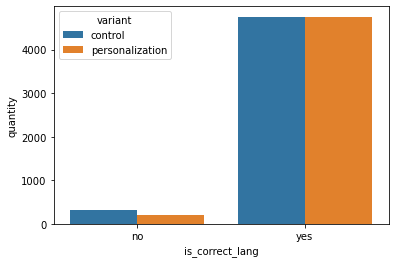

In [172]:
sns.barplot(x='is_correct_lang', y='quantity', data=users_correct_lang, hue='variant')
plt.show()

Итак, соотношение рекламы на предпочитаемом языке и нет в контрольной и тестовой группах примерно равное

Проверим, есть ли существенные отличия в А и В по возрастной группе, предпочитаемому языку и каналу привлечения

In [176]:
users_age = users.groupby(['variant','age_group'], as_index = False)\
                    .agg({'user_id':'count'})\
                    .rename(columns={'user_id':'quantity'})

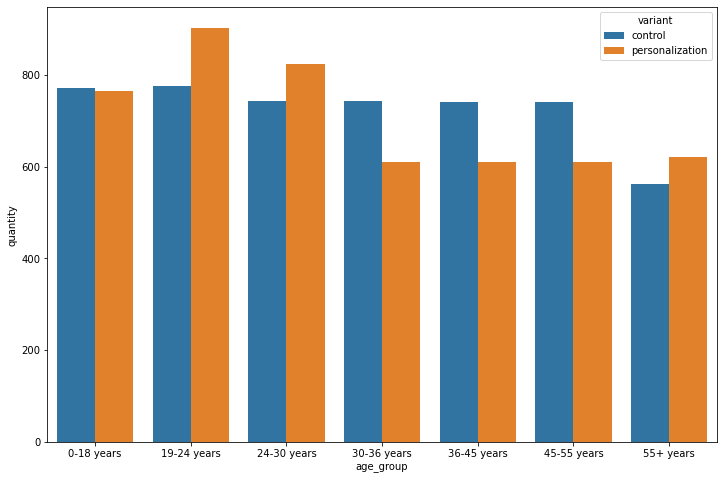

In [177]:
plt.figure(figsize=(12,8))
sns.barplot(x='age_group', y='quantity', data=users_age, hue='variant')
plt.show()

In [178]:
users_language = users.groupby(['variant','language_preferred'], as_index = False)\
                    .agg({'user_id':'count'})\
                    .rename(columns={'user_id':'quantity'})

<AxesSubplot:xlabel='language_preferred', ylabel='quantity'>

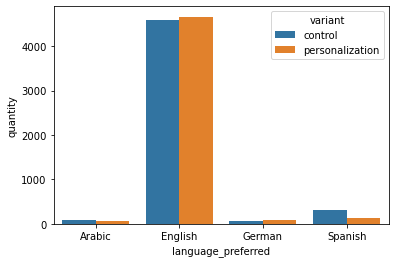

In [179]:
sns.barplot(x='language_preferred', y='quantity', data=users_language, hue='variant')

In [180]:
users_marketing_channel = users.groupby(['variant','marketing_channel'], as_index = False)\
                    .agg({'user_id':'count'})\
                    .rename(columns={'user_id':'quantity'})

<AxesSubplot:xlabel='marketing_channel', ylabel='quantity'>

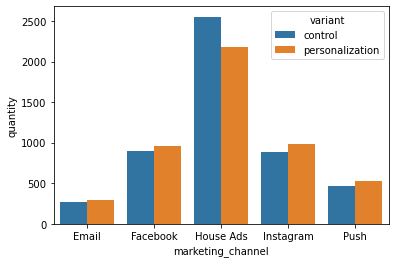

In [181]:
sns.barplot(x='marketing_channel', y='quantity', data=users_marketing_channel, hue='variant')

Можно сделать вывод, что существенных различий по таким признакам как возраст, язык, маркетинговый канал в выборках А и В нет

В качестве метрики для оценки влияния  вариантов рекламы на поведение пользователей будем использовать показатель конверсии в покупку по дням. Нулевая гипотеза будет в том, что в группах А и В нет никаких статистически значимых различий, и 2 разных варианта рекламы никак не влияют на конверсию в покупку. Планируемый уровень значимости установим равным 0.001

In [182]:
a = 0.001

In [183]:
users.date_served = pd.to_datetime(users.date_served)

In [209]:
df = users.groupby(['date_served', 'variant'], as_index=False)\
            .agg({'converted':'sum','user_id':'count'})\
            .rename(columns={'user_id':'wieved'})

In [210]:
df['convert']=df['converted']/df['wieved']

In [211]:
df.drop(['converted', 'wieved'], axis =1, inplace=True)

In [212]:
df = df.pivot(values='convert', index='date_served', columns='variant').reset_index()

In [216]:
df.head()

variant,date_served,control,personalization
0,2018-01-01,0.018634,0.163551
1,2018-01-02,0.015544,0.160714
2,2018-01-03,0.075000,0.117021
3,2018-01-04,0.098901,0.123377
4,2018-01-05,0.129213,0.124183


Проведем А/А тест для проверки того, что в группе нет никаких различий. Для этого разобьем данные на две подгруппы

In [213]:
df_aa = df["control"]

In [214]:
a1, a2 = train_test_split(df_aa,test_size=0.5,random_state=40)

<Figure size 576x432 with 0 Axes>

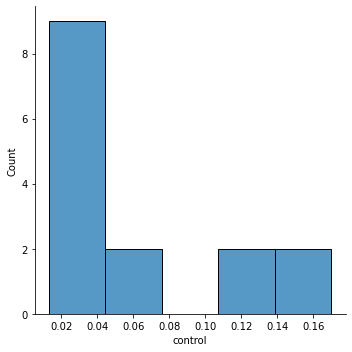

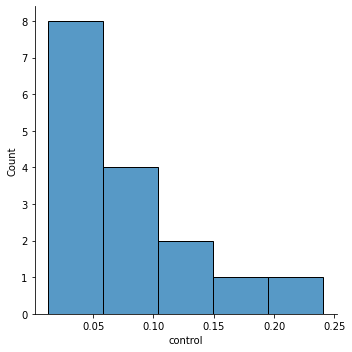

In [215]:
plt.figure(figsize=(8,6))
sns.displot(a1)
sns.displot(a2)

Так как используется относительно небольшой размер выборки, используем U-тест Манна-Уитни.

In [190]:
Statistics, p = mannwhitneyu(a1['convert'],a2['convert'])

In [191]:
print(f'Statistics = {Statistics}, p-value = {p}')

Statistics = 88.5, p-value = 0.11019228934140873


In [192]:
p<a

False

Мы получили pvalue выше заданного уровня alpha, что готовит об отсутствии статически значимых различий между А1 и А2, следовательно, обе выборки принадлежат одной генеральной совокупности.

Далее проведем А/B-тест для проверки влияния нового варианта рекламы на поведение пользователей. Нулевая гипотеза: в группах А и В нет никаких статистически значимых различий, и 2 разных варианта рекламы никак не влияют на конверсию в покупку.

Визуализируем наличие различий в группах аб-теста

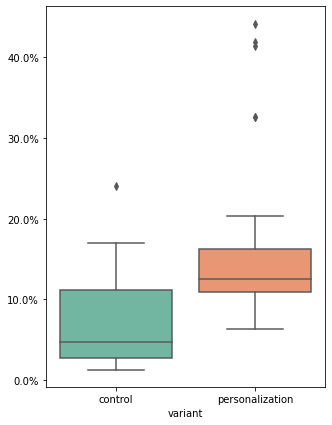

In [226]:
plt.figure(figsize=(5, 7))
ax = sns.boxplot(data=df[['control','personalization']], palette="Set2")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

Посмотрим на распределение метрики в группах

Text(0.5, 1.0, 'group A')

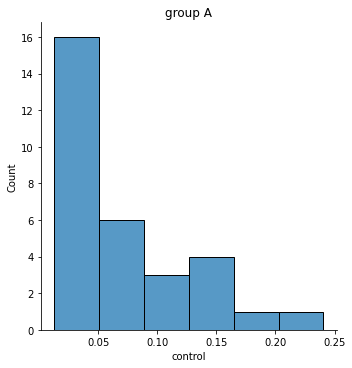

In [221]:
sns.displot(df['control'])
plt.title('group A')

Text(0.5, 1.0, 'group B')

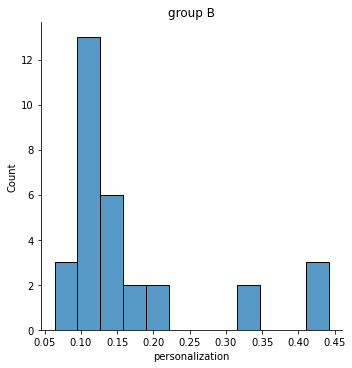

In [222]:
sns.displot(df['personalization'])
plt.title('group B')

Для проведения теста используем U-критерий Манна-Уитни

In [223]:
Statistics, p = mannwhitneyu(df['control'],df['personalization'])

In [224]:
print(f'Statistics = {Statistics}, p-value = {p}')

Statistics = 175.0, p-value = 8.769097662653401e-06


In [225]:
p<a

True

Мы получили p-уровень значимости значительно ниже 0.005, следовательно мы можем отклонить нулевую гипотезу о том, что выборки A и B принадлежат одной генеральной совокупности и никаких статистически значимых различий между А и В нет.

Итак, можно сделать вывод, что персонализируемый вариант рекламы, показанный группе В, оказывает статистически значимое влияник на нашу метрику(конверсия в покупку)